 # Prediction
 Keras on Tensorflow
 
 This prediction runs on all 9 dataset. 

In [22]:
import os, sys
import cv2
import numpy as np
import uuid
import tensorflow as tf
from skimage.io import imread, imsave, imshow
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
from imutils import paths
import itertools
import json
from pprint import pprint

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from core.imageprep import dir_checker, random_crop, crop_generator, random_crop_batch
from core.models import UNet
from core.metrics import iou_coef, dice_coef


from tensorflow.keras.models import load_model
from datetime import datetime

from core.imageprep import create_crop_idx, crop_to_patch, construct_from_patch, create_crop_idx_whole
from core.train_predict import stack_predict, stack_predict_v2
from tqdm.notebook import trange

from IPython import get_ipython
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
get_ipython().run_line_magic('load_ext', 'tensorboard')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [23]:
from packaging import version
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.0.0


 ## Load Training Dataset

In [24]:
# load image
print("Load Images...")
# on mac
# path = "/Volumes/LaCie_DataStorage/PerlmutterData/"

# on Window PC 
path = os.path.join('D:', 'PerlmutterData')

# experiment
exp_name = 'dl_seg_project_raw'

# label
label = 'lipid_droplets'

# trianing timestamp
training_date = '2019_12_06'
imginput_timestamp = '2019_12_06_17_06'
# model_training_timestamp = '2019_12_11_12_21'
model_training_timestamp = '2019_12_06_17_26'
print('Training timestamp: {}'.format(model_training_timestamp))

# input img path
imginput = os.path.join(exp_name, 'data_crop', imginput_timestamp)
imgpath = os.path.join(path, imginput)
print('Input Images Path: {}'.format(imgpath))

# model path
modelfd = 'model'
modelfn = 'model_' + model_training_timestamp + '.h5'
path_model = os.path.join(path, 'logs', modelfd, label, training_date, modelfn)
print('Model Path: {}'.format(path_model))

# raw path
rawfd = 'raw'
path_raw = os.path.join(path, rawfd)
print('Raw Path: {}'.format(path_raw))

# prediction path
pred_path = os.path.join(path, exp_name)
dir_checker('pred_img', pred_path)

Load Images...
Training timestamp: 2019_12_06_17_26
Input Images Path: D:PerlmutterData\dl_seg_project_raw\data_crop\2019_12_06_17_06
Model Path: D:PerlmutterData\logs\model\lipid_droplets\2019_12_06\model_2019_12_06_17_26.h5
Raw Path: D:PerlmutterData\raw
pred_img exists in D:PerlmutterData\dl_seg_project_raw


## Parameter

In [25]:
# load parameter
parsfd = 'pars'
parsfn = 'pars_' + model_training_timestamp + '.json'
path_pars = os.path.join(path, 'logs', parsfd, label, training_date, parsfn)

with open(path_pars) as json_file:
    pars = json.load(json_file)

In [26]:
pprint(pars)

{'IMG_HEIGHT': 256,
 'IMG_WIDTH': 256,
 'batch_size': 16,
 'classes': ['cell_membrane', 'nucleus', 'autophagosome'],
 'data_gen_img_args': {'height_shift_range': 0.1,
                       'horizontal_flip': True,
                       'rescale': 0.00392156862745098,
                       'rotation_range': 90.0,
                       'shear_range': 0.07,
                       'validation_split': 0.1,
                       'vertical_flip': True,
                       'width_shift_range': 0.1,
                       'zoom_range': 0.2},
 'data_gen_label_args': {'height_shift_range': 0.1,
                         'horizontal_flip': True,
                         'rescale': 0.00392156862745098,
                         'rotation_range': 90.0,
                         'shear_range': 0.07,
                         'validation_split': 0.1,
                         'vertical_flip': True,
                         'width_shift_range': 0.1,
                         'zoom_range': 0.2},
 'epo

In [27]:
# label = pars['inputclass']
IMG_HEIGHT = pars['IMG_HEIGHT']
IMG_WIDTH = pars['IMG_WIDTH']

## Predict from Testing Dataset

In [30]:
# get dataset
rawfdlist = os.listdir(path_raw)
print(rawfdlist)
# rawfdlist = rawfdlist[4:]

['data_d00_batch01_loc01', 'data_d00_batch02_loc02', 'data_d00_batch02_loc03', 'data_d07_batch01_loc01', 'data_d07_batch02_loc01', 'data_d07_batch02_loc02', 'data_d14_batch01_loc01', 'data_d17_batch01_loc01', 'data_d21_batch01_loc01']


In [31]:
rawimglist = {}
for folder in rawfdlist:
    print(folder)
    rawimglist[folder] = list(paths.list_images(os.path.join(path_raw, folder, 'Aligned')))

data_d00_batch01_loc01
data_d00_batch02_loc02
data_d00_batch02_loc03
data_d07_batch01_loc01
data_d07_batch02_loc01
data_d07_batch02_loc02
data_d14_batch01_loc01
data_d17_batch01_loc01
data_d21_batch01_loc01


In [32]:
# pprint(rawimglist)

## Define Prediction Set 

In [33]:
samplesize = 10
rawimglist_small = {}
for idx, item in rawimglist.items():
    rawimglist_small[idx] = rawimglist[idx][:samplesize]
# pprint(rawimglist_small)

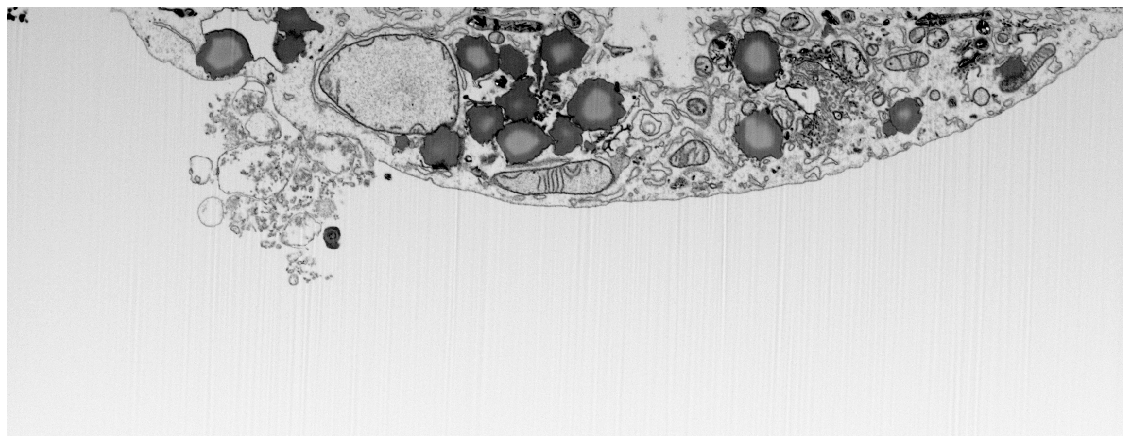

In [34]:
img = imread(rawimglist[rawfdlist[0]][500])
plt.figure(figsize = (20,20))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [35]:
'''
model = load_model(path_model, custom_objects={'iou_coef': iou_coef, 'dice_coef': dice_coef})
print(model)
'''

"\nmodel = load_model(path_model, custom_objects={'iou_coef': iou_coef, 'dice_coef': dice_coef})\nprint(model)\n"

In [36]:
learning_rate = 1e-5
loss = "binary_crossentropy"
metrics = ['accuracy', iou_coef, dice_coef]

model = UNet(shape = (None, None), 
             lr = learning_rate, 
             loss = loss,
             metrics = metrics,)

model.load_weights(path_model)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, None, None, 6 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, None, None, 6 36928       conv2d_23[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, None, None, 6 0           conv2d_24[0][0]                  
____________________________________________________________________________________________

In [37]:
img_tmp = img * 1./255.
print(img_tmp.shape)

(883, 2297)


In [38]:
# label = pars['inputclass'][0]
opdir = os.path.join(pred_path, 'pred_img')
fdnm_small = 'batch_small'

def checkpredfolder(rawfdlist, opdir, opfolder, label):
    # folder name
    dir_checker(label, opdir)
    img_path_small = os.path.join(opdir, label)
    dir_checker(opfolder, img_path_small)

    # create folder list
    for folder in rawfdlist:
        dir_checker(folder, os.path.join(img_path_small, opfolder))

checkpredfolder(rawfdlist, opdir, fdnm_small, label)


lipid_droplets exists in D:PerlmutterData\dl_seg_project_raw\pred_img
batch_small does not exist in D:PerlmutterData\dl_seg_project_raw\pred_img\lipid_droplets
data_d00_batch01_loc01 does not exist in D:PerlmutterData\dl_seg_project_raw\pred_img\lipid_droplets\batch_small
data_d00_batch02_loc02 does not exist in D:PerlmutterData\dl_seg_project_raw\pred_img\lipid_droplets\batch_small
data_d00_batch02_loc03 does not exist in D:PerlmutterData\dl_seg_project_raw\pred_img\lipid_droplets\batch_small
data_d07_batch01_loc01 does not exist in D:PerlmutterData\dl_seg_project_raw\pred_img\lipid_droplets\batch_small
data_d07_batch02_loc01 does not exist in D:PerlmutterData\dl_seg_project_raw\pred_img\lipid_droplets\batch_small
data_d07_batch02_loc02 does not exist in D:PerlmutterData\dl_seg_project_raw\pred_img\lipid_droplets\batch_small
data_d14_batch01_loc01 does not exist in D:PerlmutterData\dl_seg_project_raw\pred_img\lipid_droplets\batch_small
data_d17_batch01_loc01 does not exist in D:Perlmu

In [39]:
from core.imageprep import create_crop_idx, crop_to_patch
from core.train_predict import stack_predict_v2

for idx in trange(len(rawfdlist)):
    
    folder = rawfdlist[idx]
    
    pred_input_imgs =  rawimglist_small[folder]
    pred_output_path = os.path.join(opdir, label, fdnm_small, folder)
    
    img = imread(rawimglist_small[folder][0])
    cropidx = create_crop_idx_whole(img.shape, (IMG_HEIGHT, IMG_WIDTH), overlap_fac = 0.1)
    # print(cropidx)
    
    stack_predict_v2(
                input_imgpath = pred_input_imgs, 
                output_imgpath = pred_output_path, 
                cropidx = cropidx, 
                model = model, 
                rescale = 1./255.,
                patch_size = (IMG_HEIGHT, IMG_WIDTH), 
                predict_threshold = 0.5)


## Prediction Small Dataset with tiles
### Create Folder 

## Prediction Small Dataset with tiles (whole stack)
### Create Folder 

In [40]:
# folder name
fdnm_total = 'batch_total'
checkpredfolder(rawfdlist, opdir, fdnm_total, label)

lipid_droplets exists in D:PerlmutterData\dl_seg_project_raw\pred_img
batch_total does not exist in D:PerlmutterData\dl_seg_project_raw\pred_img\lipid_droplets
data_d00_batch01_loc01 does not exist in D:PerlmutterData\dl_seg_project_raw\pred_img\lipid_droplets\batch_total
data_d00_batch02_loc02 does not exist in D:PerlmutterData\dl_seg_project_raw\pred_img\lipid_droplets\batch_total
data_d00_batch02_loc03 does not exist in D:PerlmutterData\dl_seg_project_raw\pred_img\lipid_droplets\batch_total
data_d07_batch01_loc01 does not exist in D:PerlmutterData\dl_seg_project_raw\pred_img\lipid_droplets\batch_total
data_d07_batch02_loc01 does not exist in D:PerlmutterData\dl_seg_project_raw\pred_img\lipid_droplets\batch_total
data_d07_batch02_loc02 does not exist in D:PerlmutterData\dl_seg_project_raw\pred_img\lipid_droplets\batch_total
data_d14_batch01_loc01 does not exist in D:PerlmutterData\dl_seg_project_raw\pred_img\lipid_droplets\batch_total
data_d17_batch01_loc01 does not exist in D:Perlmu

### Tiling Prediction with Stack Input
- Crop image into patched by a given overlap factor
- Export a cropping index
- Construct patches back into a image 

In [41]:
from core.imageprep import create_crop_idx, crop_to_patch
from core.train_predict import stack_predict_v2

for idx in trange(len(rawfdlist)):
    
    folder = rawfdlist[idx]
    
    pred_input_imgs =  rawimglist[folder]
    pred_output_path = os.path.join(opdir, label, fdnm_total, folder)
    
    img = imread(rawimglist_small[folder][0])
    cropidx = create_crop_idx_whole(img.shape, (IMG_HEIGHT, IMG_WIDTH), overlap_fac = 0.1)
    # print(cropidx)
    
    stack_predict_v2(
                input_imgpath = pred_input_imgs, 
                output_imgpath = pred_output_path, 
                cropidx = cropidx, 
                model = model, 
                rescale = 1./255.,
                patch_size = (IMG_HEIGHT, IMG_WIDTH), 
                predict_threshold = 0.5)
